In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
#from scipy import stats
print("imports complete")


imports complete


C:\Users\GHarrison\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 # Outliers

 A boxplot showing the median and inter-quartile ranges is a good way to visualise a distribution, especially when
 the data contains outliers. The meaning of the various aspects of a box plot can be visualised as follows -

 ![](images/IQR.png)

 ## Generating some data
 We are going to need some test data to explore the issues around outliers

 ### Function Definition

 The generate() function below (taken from Stack Overflow) will generate a list of floats
 with a given median that contains outliers (values a long way from the median) which we can
 use to explore the concept.

In [2]:
def generate(median=630, err=12, outlier_err=100, size=80, outlier_size=10):
    np.random.seed(median)
    errs = err * np.random.rand(size) * np.random.choice((-1, 1), size)
    data = median + errs

    lower_errs = outlier_err * np.random.rand(outlier_size)
    lower_outliers = median - err - lower_errs

    upper_errs = outlier_err * np.random.rand(outlier_size)
    upper_outliers = median + err + upper_errs

    data = np.concatenate((data, lower_outliers, upper_outliers))
    np.random.shuffle(data)

    return data


 ### Function Testing

 Let's get the results of generate() into a DataFrame so we can take a look at the output ...

In [3]:
df_test = pd.DataFrame(generate())
df_test.head()


,0
0,729.346989
1,625.517946
2,628.131548
3,728.244689
4,523.220860


 ## Creating some meaningful data

 The following creates a dataframe with 3 columns with means of 630, 740 and 220 which contain ouutlying values

In [4]:
df = pd.DataFrame({'Col0': generate(median=630), 'Col1': generate(median=740), 'Col2': generate(median=220)})
df.head()


,Col0,Col1,Col2
0,729.346989,732.344105,279.715383
1,625.517946,745.195532,223.136746
2,628.131548,743.745312,213.111157
3,728.244689,740.958763,216.648211
4,523.220860,748.678124,222.700787


 ## Working with outliers

 Let's start by taking another look at the explanation -

 ![](images/IQR.png)

 ### Helpder functions

 The functions below looks at a column of values within a data frame and calculates
 the 1st and 3rd quartiles, the inter-quartile range and the minimum and maximum
 Any value outside of the miniumum and maximum is an outlier

In [5]:
# (modified from http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)
def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.75) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text(df_in, col_name):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values(df_in, col_name)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

def box_and_whisker(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

print("functions defined")

functions defined


 ## Visualising the data

 sns.boxplot is used to visualise our 3 columns of data; the outliers are the dots that lie
 outside of the |- and -| whiskers ...

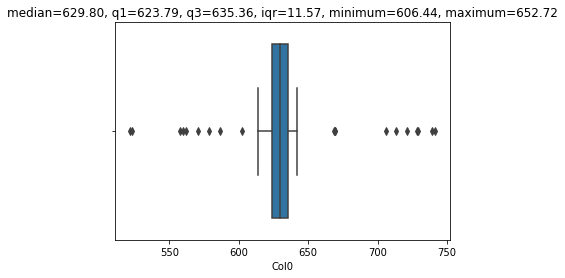

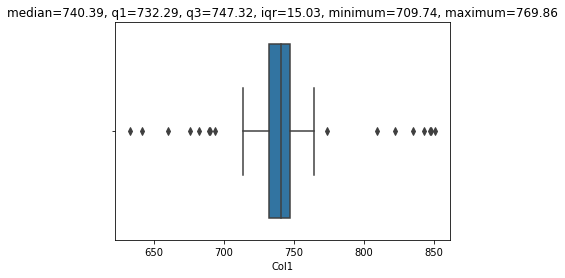

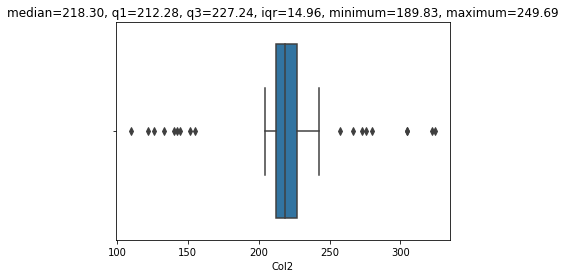

In [6]:
box_and_whisker(df, 'Col0')
box_and_whisker(df, 'Col1')
box_and_whisker(df, 'Col2')

_, _, _, _, minimum_Col1_before, maximum_Col1_before = get_iqr_values(df, 'Col1')


In [7]:
print(f"Col0 has {count_outliers(df, 'Col0')} outliers")
print(f"Col1 has {count_outliers(df, 'Col1')} outliers")
print(f"Col2 has {count_outliers(df, 'Col2')} outliers")


Col0 has 19 outliers
Col1 has 16 outliers
Col2 has 18 outliers


 ## Removing the outliers

 Having done all the heavy lifting in the helpder functions we can now go ahead and remove the rows from the outliers
 outside of the |- and -| whiskers ...

In [8]:
print(f"rows before removing: {df.shape[0]}")
df = remove_outliers(df, 'Col0')
df = remove_outliers(df, 'Col1')
df = remove_outliers(df, 'Col2')
print(f"rows after removing: {df.shape[0]}")


rows before removing: 100
rows after removing: 56


 ## Visualise the result

 Let's have a look at the end-result. Here is something very strange though, our data still appears to have outliers!

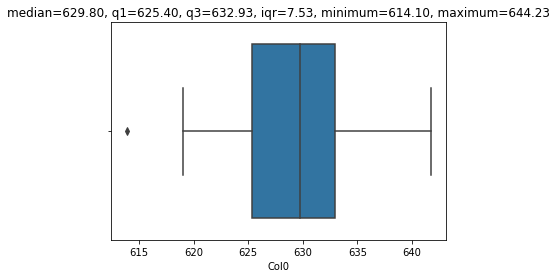

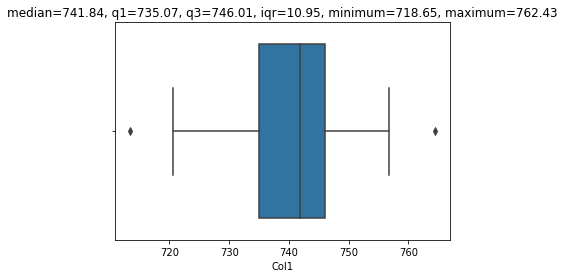

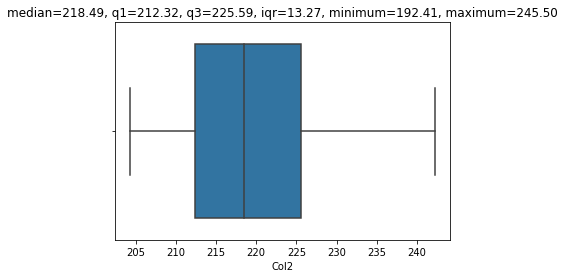

In [9]:
box_and_whisker(df, 'Col0')
box_and_whisker(df, 'Col1')
box_and_whisker(df, 'Col2')

_, _, _, _, minimum_Col1_after, maximum_Col1_after = get_iqr_values(df, 'Col1')


 ## Explain the result

 The reason that Col0 and Col1 still appear to have outliers is that we removed the outliers based on the
 minimum and maximum of the dataframe before we modified it with

   df = remove_outliers(df, 'Col0')
   df = remove_outliers(df, 'Col1')
   df = remove_outliers(df, 'Col2')

 Once the data has been changed some values will be retained that were close to the original boundaries but
 after the modification the boundaries will change leaving some of the values outside of the new boundaries

In [10]:
print(f"Col1 original boundaries: minium={minimum_Col1_before:.2f}, maximum={maximum_Col1_before:.2f}")
print(f"Col1 new minimum and maximum values: minium={df['Col1'].min():.2f}, maximum={df['Col1'].max():.2f}")
print(f"Col1 new boundaries: minium={minimum_Col1_after:.2f}, maximum={maximum_Col1_after:.2f}")
print("")
print(f"Col0 has {count_outliers(df, 'Col0')} outliers")
print(f"Col1 has {count_outliers(df, 'Col1')} outliers")
print(f"Col2 has {count_outliers(df, 'Col2')} outliers")


Col1 original boundaries: minium=709.74, maximum=769.86
Col1 new minimum and maximum values: minium=713.45, maximum=764.40
Col1 new boundaries: minium=718.65, maximum=762.43

Col0 has 1 outliers
Col1 has 2 outliers
Col2 has 0 outliers


 ## Resolve the result

 We can either accept this slightly strange looking result or we can keep on trimming outliers until
 there are non left in the updated data frame ..

Col0 has 0 outliers


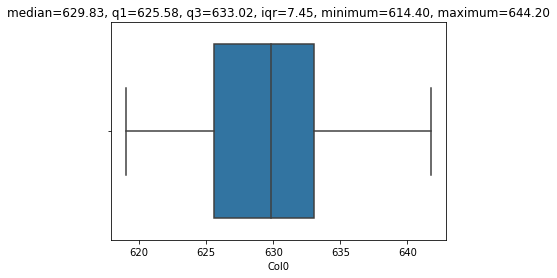

Col1 has 0 outliers


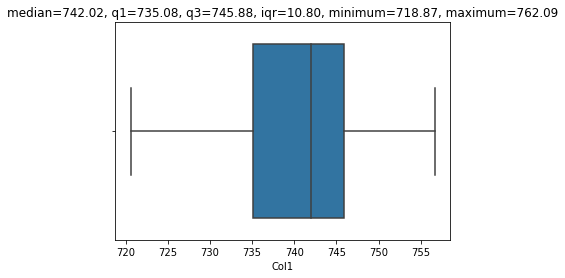

Col2 has 0 outliers


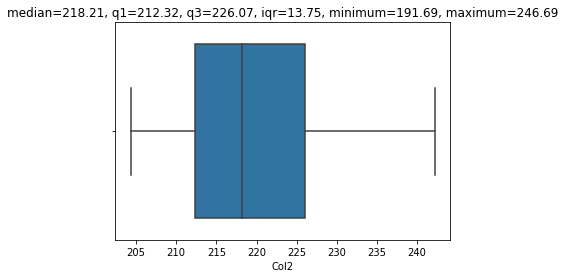

In [11]:
for column in df:
    loop_count = 0
    outlier_count = count_outliers(df, column)
    while outlier_count > 0:
        df = remove_outliers(df, column)
        outlier_count = count_outliers(df, column)
        loop_count += 1
        if (loop_count > 100):
            break

    print(f"{column} has {count_outliers(df, column)} outliers")
    box_and_whisker(df, column)


 ## Conclusion

 We have generated some test data with outliers to explore the probem space and then built some
 helper functions to resolve them.

 Having removed the outliers using the inter quartile ranges we noted that there appeared to be some
 left near the tails and explained this result as follow; the remaining outliers were not quite outliers
 in the original data but when we modified the data by trimming the original outliers the boundaries changed.

 This is an odd looking result. We can either accept it, as the point of removing outliers would usually be
 to remove outlandish values skewing the results or the models the results will be used in, or we can simply
 iterate around the data removing outliers until they are all gone. Two iterations usually suffices but the
 function provided keeps going until they are all gone